**PART 2: Preprocessing**

Importing useful libraries at first

In [17]:
import pandas as pd
import numpy as np


import matplotlib.pyplot as plt
import matplotlib.lines as mlines
import seaborn as sns
%matplotlib inline
pd.set_option('max_colwidth',200)
pd.set_option('max_columns',200)
SEED = 100

import warnings
warnings.filterwarnings("ignore")

import pickle
import time

import re
from bs4 import BeautifulSoup
import nltk
from nltk.tokenize import ToktokTokenizer
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.corpus import stopwords
from string import punctuation

import torch
from torch import nn ,cuda
from torch.utils.data import DataLoader,Dataset,RandomSampler, SequentialSampler

np.random.seed(SEED)

In [18]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [19]:
# Importing the database 

with open('/content/drive/MyDrive/thesis/cleaned_dataframe.pkl', 'rb') as f:
    new_df,tags_features = pickle.load(f)

In [20]:
new_df.head(5)

,Title,Body,Tags,no_of_tags
4,Adding scripting functionality to .NET applications,"<p>I have a little game written in C#. It uses a database as back-end. It's \na <a href=""http://en.wikipedia.org/wiki/Collectible_card_game"">trading card game</a>, and I wanted to implement the fu...","[c#, .net]",2
5,Should I use nested classes in this case?,"<p>I am working on a collection of classes used for video playback and recording. I have one main class which acts like the public interface, with methods like <code>play()</code>, <code>stop()</c...",[c++],1
6,Homegrown consumption of web services,"<p>I've been writing a few web services for a .net app, now I'm ready to consume them. I've seen numerous examples where there is homegrown code for consuming the service as opposed to using the a...",[.net],1
8,Automatically update version number,<p>I would like the version property of my application to be incremented for each build but I'm not sure on how to enable this functionality in Visual Studio (2005/2008). I have tried to specify t...,[c#],1
10,How do I connect to a database and loop over a recordset in C#?,<p>What's the simplest way to connect and query a database for a set of records in C#?</p>\n,[c#],1


**1.2.2 Body**

In the next two columns: Body and Title, I'll use lots of text processing:
* Removing html format 
* Lowering text
* Transforming abbreviations 
* Removing punctuation (but keeping words like c# since it's the most popular tag)
* Lemmatizing words
* Removing stop words

In [21]:
# Converting html to text in the body

new_df['Body'] = new_df['Body'].apply(lambda x: BeautifulSoup(x).get_text()) 

In [22]:
def clean_text(text):
    text = text.lower()
    text = re.sub(r"what's", "what is ", text)
    text = re.sub(r"\'s", " ", text)
    text = re.sub(r"\'ve", " have ", text)
    text = re.sub(r"can't", "can not ", text)
    text = re.sub(r"n't", " not ", text)
    text = re.sub(r"i'm", "i am ", text)
    text = re.sub(r"\'re", " are ", text)
    text = re.sub(r"\'d", " would ", text)
    text = re.sub(r"\'ll", " will ", text)
    text = re.sub(r"\'scuse", " excuse ", text)
    text = re.sub(r"\'\n", " ", text)
    text = re.sub(r"\'\xa0", " ", text)
    text = re.sub('\s+', ' ', text)
    text = text.strip(' ')
    return text

In [23]:
new_df['Body'] = new_df['Body'].apply(lambda x: clean_text(x)) 

In [24]:
token=ToktokTokenizer()

In [25]:
punctuation

'!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [26]:
punct = '!"#$%&\'()*+,./:;<=>?@[\\]^_`{|}~'

In [27]:
def strip_list_noempty(mylist):
    newlist = (item.strip() if hasattr(item, 'strip') else item for item in mylist)
    return [item for item in newlist if item != '']

In [28]:
def clean_punct(text): 
    words=token.tokenize(text)
    punctuation_filtered = []
    regex = re.compile('[%s]' % re.escape(punct))
    remove_punctuation = str.maketrans(' ', ' ', punct)
    for w in words:
        if w in tags_features:
            punctuation_filtered.append(w)
        else:
            punctuation_filtered.append(regex.sub('', w))
  
    filtered_list = strip_list_noempty(punctuation_filtered)
        
    return ' '.join(map(str, filtered_list))




In [29]:
new_df['Body'] = new_df['Body'].apply(lambda x: clean_punct(x)) 

In [30]:
import nltk
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')

lemma=WordNetLemmatizer()
stop_words = set(stopwords.words("english"))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


In [31]:
def lemitizeWords(text):
    words=token.tokenize(text)
    listLemma=[]
    for w in words:
        x=lemma.lemmatize(w, pos="v")
        listLemma.append(x)
    return ' '.join(map(str, listLemma))

def stopWordsRemove(text):
    
    stop_words = set(stopwords.words("english"))
    
    words=token.tokenize(text)
    
    filtered = [w for w in words if not w in stop_words]
    
    return ' '.join(map(str, filtered))

In [32]:
def create_corpus():
    corpus = []
    
    for x in new_df['Body'].str.split():
        for i in x:
            corpus.append(i)
    return corpus

corpus = create_corpus()

In [33]:
new_df['Body'] = new_df['Body'].apply(lambda x: lemitizeWords(x)) 
new_df['Body'] = new_df['Body'].apply(lambda x: stopWordsRemove(x)) 

**1.2.3 Title**

In [34]:
new_df['Title'] = new_df['Title'].apply(lambda x: str(x))
new_df['Title'] = new_df['Title'].apply(lambda x: clean_text(x)) 
new_df['Title'] = new_df['Title'].apply(lambda x: clean_punct(x)) 
new_df['Title'] = new_df['Title'].apply(lambda x: lemitizeWords(x)) 
new_df['Title'] = new_df['Title'].apply(lambda x: stopWordsRemove(x)) 

In [35]:
new_df.head(5)

,Title,Body,Tags,no_of_tags
4,add script functionality .net applications,little game write c use database back-end trade card game want implement function card script mean essentially interface icard card class implement public class card056 icard contain function call...,"[c#, .net]",2
5,use nest class case,work collection class use video playback record one main class act like public interface methods like play stop pause record etc workhorse class video decode video encode learn existence nest clas...,[c++],1
6,homegrown consumption web service,write web service .net app ready consume see numerous examples homegrown code consume service oppose use auto generate methods visual studio create add web reference advantage,[.net],1
8,automatically update version number,would like version property application incremented build sure enable functionality visual studio 20052008 try specify assemblyversion 10 get exactly want also use settings file earlier attempt as...,[c#],1
10,connect database loop recordset c#,simplest way connect query database set record c#,[c#],1


In [36]:
with open('/content/drive/MyDrive/thesis/preprocessed_dataframe.pkl', 'wb') as f:
    pickle.dump(new_df, f)

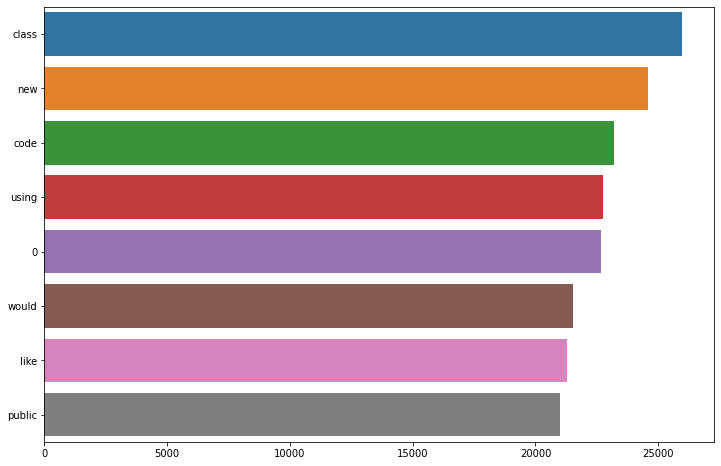

In [40]:
from collections import Counter, defaultdict


counter = Counter(corpus)
most = counter.most_common()
x = []
y = []
for word,count in most[:40]:
    if (word not in set(stopwords.words('english'))) :
        x.append(word)
        y.append(count)

plt.figure(figsize = (12, 8))

sns.barplot(x = y,y = x)
plt.savefig('/content/drive/MyDrive/thesis/img/top_common_words_questions.png', dpi=300)
plt.show()

In [38]:
from sklearn.feature_extraction.text import CountVectorizer
def get_top_ques_bigrams(corpus, n = None):
    vec = CountVectorizer(ngram_range = (2, 2)).fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis = 0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq = sorted(words_freq, key = lambda x: x[1], reverse = True)
    return words_freq[:n]

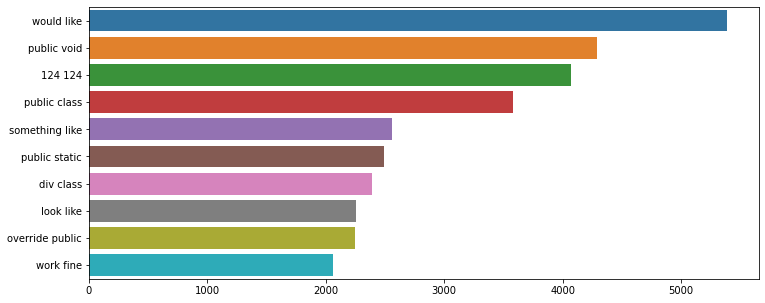

In [41]:
plt.figure(figsize = (12, 5))
top_ques_bigrams = get_top_ques_bigrams(new_df['Body'])[:10]
x, y = map(list,zip(*top_ques_bigrams))
sns.barplot(x = y, y = x)
plt.savefig('/content/drive/MyDrive/thesis/img/top_ques_bigrams.png', dpi=300)
plt.show()